In [1]:
import boto3
import pandas as pd
import time
 
# --- Configuration ---
region = 'ap-south-1'  # change to your region
workgroup_name = 'default-workgroup'
database_name = 'dev'
secret_arn = 'arn:aws:secretsmanager:ap-south-1:820028474211:secret:redshift-secret-nxgY56'
sql = 'SELECT * FROM lead_pre'
 
# --- Create boto3 Redshift Data API client ---
client = boto3.client('redshift-data', region_name=region)
 
# --- Execute query ---
response = client.execute_statement(
    WorkgroupName='default-workgroup',
    Database='dev',
    SecretArn='arn:aws:secretsmanager:ap-south-1:820028474211:secret:redshift-secret-nxgY56',
    Sql=sql
)
 
statement_id = response['Id']
 
# --- Wait for completion ---
desc = client.describe_statement(Id=statement_id)
while desc['Status'] not in ['FINISHED', 'FAILED', 'ABORTED']:
    time.sleep(1)
    desc = client.describe_statement(Id=statement_id)
 
if desc['Status'] != 'FINISHED':
    raise Exception(f"Query failed: {desc}")
 
# --- Retrieve results ---
result = client.get_statement_result(Id=statement_id)
 
# --- Convert to pandas DataFrame ---
columns = [col['name'] for col in result['ColumnMetadata']]
rows = result['Records']
 
data = []
for row in rows:
    data.append([list(col.values())[0] if col else None for col in row])
 
df = pd.DataFrame(data, columns=columns)
print(df.head())

     city do_not_call  converted what_is_your_current_occupation    \
0  Select          No          0                        Unemployed   
1  Select          No          0                        Unemployed   
2  Mumbai          No          1                           Student   
3  Mumbai          No          0                        Unemployed   
4  Mumbai          No          1                        Unemployed   

   total_time_spent_on_website x_education_forums through_recommendations  \
0                            0                 No                      No   
1                          674                 No                      No   
2                         1532                 No                      No   
3                          305                 No                      No   
4                         1428                 No                      No   

  magazine what_matters_most_to_you_in_choosing_a_course search  ...  \
0       No                       Better Care

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
#from feature_engine.outliers import Winsorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import mlflow
from mlflow.tracking import MlflowClient
import shap
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import re
import shap
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings("ignore")

In [26]:
df.describe()

,do_not_call,converted,total_time_spent_on_website,through_recommendations,magazine,search,a_free_copy_of_mastering_the_interview,do_not_email,lead_number,digital_advertisement,i_agree_to_pay_the_amount_through_cheque,receive_more_updates_about_our_courses,newspaper_article,get_updates_on_dm_content,newspaper
count,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
mean,0.0,0.380000,535.440000,0.0,0.0,0.0,0.250000,0.030000,660109.910000,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.487832,526.985621,0.0,0.0,0.0,0.435194,0.171447,371.216757,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,659507.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.000000,94.000000,0.0,0.0,0.0,0.000000,0.000000,659781.250000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.000000,322.500000,0.0,0.0,0.0,0.000000,0.000000,660107.500000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,1.000000,1008.250000,0.0,0.0,0.0,0.250000,0.000000,660449.750000,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,1.000000,1710.000000,0.0,0.0,0.0,1.000000,1.000000,660737.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df.isnull().sum()

city                                             38
do_not_call                                       0
converted                                         0
what_is_your_current_occupation                  17
total_time_spent_on_website                       0
x_education_forums                                0
through_recommendations                           0
magazine                                          0
what_matters_most_to_you_in_choosing_a_course    17
search                                            0
update_me_on_supply_chain_content                 0
lead_source                                       0
totalvisits                                       0
tags                                             22
how_did_you_hear_about_x_education               73
a_free_copy_of_mastering_the_interview            0
do_not_email                                      0
lead_number                                       0
digital_advertisement                             0
asymmetrique

In [28]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [29]:
df = df.loc[:, ~df.columns.duplicated()]


In [30]:
df.replace(["Select", "", None], np.nan, inplace=True)

In [31]:
binary_cols = [
    "do_not_email", "do_not_call", "search", "magazine", "newspaper_article",
    "newspaper", "digital_advertisement", "through_recommendations",
    "receive_more_updates_about_our_courses", "get_updates_on_dm_content",
    "i_agree_to_pay_the_amount_through_cheque", "a_free_copy_of_mastering_the_interview"
]
binary_map = {"Yes": 1, "No": 0}
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map(binary_map)

In [32]:
#  Define features and target
X = df.drop(columns=["converted"])
y = df["converted"]


📊 Class distribution:
converted
0    62
1    38
Name: count, dtype: int64


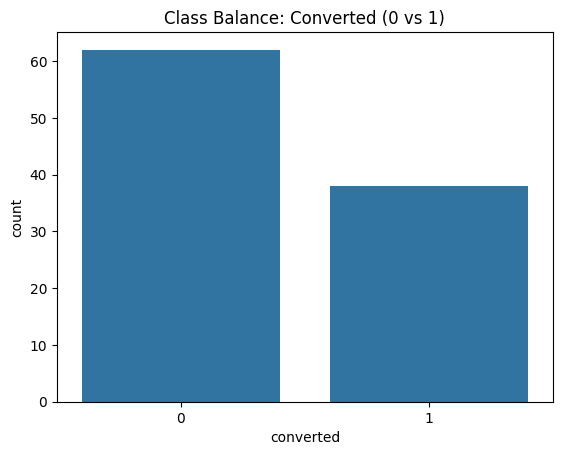

In [33]:
# Check class imbalance
print("\n📊 Class distribution:")
print(y.value_counts())
sns.countplot(x=y)
plt.title("Class Balance: Converted (0 vs 1)")
plt.show()

# Apply SMOTE only after train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# 📊 Class distribution before SMOTE
print("\n📊 Class distribution before SMOTE:")
print(y_train.value_counts())

# 🔢 Shape before SMOTE
print(f"\n📏 Shape before SMOTE:\nX_train_raw: {X_train_raw.shape}\ny_train: {y_train.shape}")



📊 Class distribution before SMOTE:
converted
0    51
1    29
Name: count, dtype: int64

📏 Shape before SMOTE:
X_train_raw: (80, 36)
y_train: (80,)


In [41]:
# Function to build and save a preprocessing pipeline
def build_preprocessing_pipeline(X, ordinal_features, ordinal_mapping, pipeline_path="preprocess.pkl"):
    # Identify numeric and categorical columns from input DataFrame X
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Ensure only those ordinal features that actually exist in the data are used
    ordinal_features = list(set(ordinal_features) & set(categorical_features))
    
    # Remove ordinal features from the general categorical list
    categorical_features = list(set(categorical_features) - set(ordinal_features))

    # Numeric preprocessing: impute missing values with median, then scale to [0, 1]
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
    ])

    # Categorical preprocessing: impute missing values with the most frequent category, then one-hot encode
    categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder( handle_unknown='infrequent_if_exist', min_frequency=0.05,sparse_output=False ))
    ])


    # Ordinal preprocessing: impute with most frequent value, then apply ordinal encoding using provided mappings
    ordinal_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=ordinal_mapping))
    ])

    # Combine all sub-pipelines using ColumnTransformer
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
        ("ord", ordinal_pipeline, ordinal_features)
    ])

    # Save the entire preprocessing pipeline to disk for reuse
    joblib.dump(preprocessor, pipeline_path)
    print(f"✅ Preprocessing pipeline saved at: {pipeline_path}")
    
    return preprocessor, numeric_features, categorical_features


# Define ordinal features and their ordering
ordinal_features = ['asymmetrique_activity_index', 'asymmetrique_profile_index']
ordinal_mapping = [['03.Low', '02.Medium', '01.High']] * len(ordinal_features)

# Call the preprocessing function to build and save the pipeline
preprocessor, num_cols, cat_cols = build_preprocessing_pipeline(
    X_train_raw, ordinal_features, ordinal_mapping
)

# Fit the preprocessor on training data and transform it
X_train_processed = preprocessor.fit_transform(X_train_raw)

# Apply the same transformation to test data without fitting again
X_test_processed = preprocessor.transform(X_test_raw)


# Apply SMOTE to handle class imbalance in the training data
print("\n🔄 Applying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Output the new class distribution after balancing
print("\n✅ Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


✅ Preprocessing pipeline saved at: preprocess.pkl

🔄 Applying SMOTE to balance classes...

✅ Class distribution after SMOTE:
converted
0    51
1    51
Name: count, dtype: int64


In [42]:
# Check shape after SMOTE
print(f"\n🔢 Shape after SMOTE:\nX_train_balanced: {X_train_balanced.shape}\ny_train_balanced: {y_train_balanced.shape}")



🔢 Shape after SMOTE:
X_train_balanced: (102, 75)
y_train_balanced: (102,)


In [43]:
# Function to transform the data using a fitted preprocessor and return a DataFrame with proper column names
def transform_data(X, preprocessor, numeric_features, categorical_features, ordinal_features=None):
    # Apply the preprocessing pipeline: fit and transform the input data
    processed = preprocessor.fit_transform(X)
    
    try:
        # Extract the one-hot encoder object from the 'cat' pipeline
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        
        # Get the new feature names created by one-hot encoding the categorical variables
        cat_feature_names = ohe.get_feature_names_out(categorical_features)

        # Use ordinal feature names as-is, since ordinal encoding doesn’t create new feature names
        if ordinal_features:
            ord_feature_names = ordinal_features
        else:
            ord_feature_names = []

        # Combine all column names: numeric, one-hot encoded categorical, and ordinal
        all_columns = numeric_features + list(cat_feature_names) + ord_feature_names

        # Return the transformed data as a DataFrame with appropriate column names
        return pd.DataFrame(processed, columns=all_columns)

    except Exception as e:
        # Handle any error (e.g., when feature names can't be extracted) and return unnamed DataFrame
        print(f"⚠️ Could not extract feature names: {e}")
        return pd.DataFrame(processed)

In [38]:
# Function to evaluate classification model performance
def evaluate_classification_model(y_true, y_pred, y_proba):
    return {
        # Overall accuracy: how many predictions were correct
        "accuracy": accuracy_score(y_true, y_pred),

        # Precision: of the predicted positives, how many are actually positive
        "precision": precision_score(y_true, y_pred, zero_division=0),

        # Recall: of all actual positives, how many did we correctly identify
        "recall": recall_score(y_true, y_pred, zero_division=0),

        # F1-score: harmonic mean of precision and recall (useful for imbalanced datasets)
        "f1": f1_score(y_true, y_pred, zero_division=0),

        # ROC-AUC: area under the Receiver Operating Characteristic curve (requires probabilities)
        "roc_auc": roc_auc_score(y_true, y_proba)
    }


In [44]:
    # Train multiple models, log results to MLflow, and generate SHAP explanations
    def train_log_and_shap(models, X_train, y_train, X_val, y_val,
                           preprocessor, feature_names,
                           save_dir="saved_models", shap_dir="shap_outputs"):
        
        # Create directories if they don't exist
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(shap_dir, exist_ok=True)
    
        # Set MLflow tracking server and experiment name
        mlflow.set_tracking_uri("arn:aws:sagemaker:ap-south-1:820028474211:mlflow-tracking-server/mlflow-sg")
        mlflow.set_experiment("Lead Conversion Prediction v3")
    
        results = []       # Stores evaluation metrics for all models
        best_models = {}   # Stores best trained model per algorithm
    
        # Iterate over each model and its hyperparameters
        for name, model_info in models.items():
            print(f"\n🔧 Training: {name}")
    
            # Perform grid search with 3-fold cross-validation, optimizing for F1-score
            grid = GridSearchCV(model_info['model'], model_info['params'],
                                cv=3, scoring='f1', n_jobs=-1)
            grid.fit(X_train, y_train)
    
            # Predict on validation set
            y_pred = grid.predict(X_val)
            # If model supports probabilities, get them for ROC-AUC
            y_proba = grid.predict_proba(X_val)[:, 1] if hasattr(grid, "predict_proba") else y_pred
    
            #  Evaluate the model
            metrics = evaluate_classification_model(y_val, y_pred, y_proba)
            results.append({"model": name, "best_params": grid.best_params_, **metrics})
            best_models[name] = grid.best_estimator_
    
            #  Save the best model to disk
            model_path = os.path.join(save_dir, f"{name}_best_model.pkl")
            joblib.dump(grid.best_estimator_, model_path)
    
            # Log to MLflow
            with mlflow.start_run(run_name=name) as run:
                mlflow.log_params(grid.best_params_)
                mlflow.log_metrics(metrics)
                mlflow.sklearn.log_model(grid.best_estimator_, "model")
    
                #  Generate SHAP explanations
                try:
                    # Convert input back to DataFrame (required for SHAP)
                    X_val_df = pd.DataFrame(X_val, columns=feature_names)
                    fitted_model = grid.best_estimator_
    
                    # Use appropriate SHAP explainer based on model type
                    if isinstance(fitted_model, (DecisionTreeClassifier, RandomForestClassifier, XGBClassifier)):
                        explainer = shap.TreeExplainer(fitted_model)
                        shap_values = explainer.shap_values(X_val_df)
                    elif isinstance(fitted_model, LogisticRegression):
                        explainer = shap.Explainer(fitted_model, X_val_df)
                        shap_values = explainer(X_val_df)
                    else:
                        print(f"⚠️ SHAP skipped for {name}: Unsupported model type.")
                        continue
    
                    # Save SHAP summary plot to disk
                    shap_path = os.path.join(shap_dir, f"{name}_shap_summary.png")
                    plt.figure()
                    shap.summary_plot(shap_values, X_val_df, show=False)
                    plt.savefig(shap_path, bbox_inches="tight")
                    plt.close()
    
                    # Log SHAP plot to MLflow
                    mlflow.log_artifact(shap_path, artifact_path="shap_plots")
                    print(f"✅ SHAP saved & logged: {shap_path}")
    
                except Exception as e:
                    print(f"⚠️ SHAP failed for {name}: {e}")
    
        #  Compile all metrics into a summary DataFrame
        results_df = pd.DataFrame(results)
        print("\n📊 All Model Validation Metrics:")
        print(results_df[["model", "accuracy", "precision", "recall", "f1", "roc_auc"]].to_string(index=False))
    
        return results_df, best_models
    # Save, retrain, and register the best-performing model using MLflow
    def save_and_register_best_model_pipeline(results_df, best_models,
                                              X_train_val, y_train_val,
                                              preprocessor,
                                              save_dir="saved_models"):
    
        # 📁 Ensure save directory exists
        os.makedirs(save_dir, exist_ok=True)
    
        # 🔍 Step 1: Identify the best model based on ROC AUC (descending)
        best_model_name = results_df.sort_values(by="roc_auc", ascending=False).iloc[0]["model"]
        best_model = best_models[best_model_name]
        print(f"\n🏆 Best model selected: {best_model_name}")
    
        # 🔁 Step 2: Retrain the best model on full training + validation dataset
        best_model.fit(X_train_val, y_train_val)
    
        # 🛠️ Step 3: Build a complete pipeline with preprocessing and model
        full_pipeline = Pipeline([
            ("preprocessing", preprocessor),
            ("model", best_model)
        ])
    
        # 💾 Step 4: Save the final pipeline locally as a .pkl file
        model_path = os.path.join(save_dir, f"final_{best_model_name}_pipeline.pkl")
        joblib.dump(full_pipeline, model_path)
        print(f"✅ Final pipeline saved at: {model_path}")
    
        # 🧪 Step 5: Log and register the model in MLflow Model Registry
        mlflow.set_tracking_uri("arn:aws:sagemaker:ap-south-1:820028474211:mlflow-tracking-server/mlflow-sg")  # Local MLflow tracking server
        mlflow.set_experiment("Lead Conversion Prediction v3")  # Set the experiment
        client = MlflowClient()  # MLflow client for advanced registry actions
    
        with mlflow.start_run(run_name=f"Final_{best_model_name}") as run:
            run_id = run.info.run_id
    
            # ✅ Log the full pipeline with sklearn flavor
            mlflow.sklearn.log_model(full_pipeline, artifact_path="model")
    
            print(f"🔁 Registering model to MLflow Model Registry: {best_model_name}")
            model_uri = f"runs:/{run_id}/model"
    
            # 🔐 Register the model under the given name
            registered_model = mlflow.register_model(
                model_uri=model_uri,
                name=best_model_name
            )
    
            # 🕒 Wait for model to fully register (prevents race conditions)
            time.sleep(10)
    
            # ✅ Transition model version to "Production" stage
            client.transition_model_version_stage(
                name=best_model_name,
                version=registered_model.version,
                stage="Production",
                archive_existing_versions=True  # Archive any previous version
            )
            print(f"✅ Model '{best_model_name}' version {registered_model.version} moved to 'Production'.")
    
            # 🏷️ Optionally assign alias "champion" to this production version
            try:
                client.set_model_version_alias(
                    name=best_model_name,
                    version=registered_model.version,
                    alias="champion"
                )
                print(f"🏷️ Alias 'champion' assigned to version {registered_model.version}.")
            except Exception as e:
                print(f"⚠️ Unable to set alias 'champion': {e}")
    
            # 🔗 Provide direct link to MLflow run
            print(f"🏃 View run: http://localhost:5000/#/experiments/{run.info.experiment_id}/runs/{run_id}")
    
        # ✅ Return pipeline, model name, and file path for reuse
        return full_pipeline, best_model_name, model_path

In [45]:
# Reload a saved pipeline, retrain it on full data, evaluate, and save again
def retrain_loaded_pipeline(model_path, processed, y, save_path="saved_models/final_lead_model_retrained.pkl"):
    
    # 📦 Load the full pipeline (including preprocessing and model)
    print(f"\n📦 Loading pipeline from: {model_path}")
    model = joblib.load(model_path)

    # 🔁 Retrain model on the full dataset
    model.fit(processed, y)

    # 🔮 Make predictions on the same data
    preds = model.predict(processed)
    # Get prediction probabilities if available (for ROC AUC)
    proba = model.predict_proba(processed)[:, 1] if hasattr(model, 'predict_proba') else None

    # 🧪 Compute standard classification metrics
    accuracy  = accuracy_score(y, preds)
    precision = precision_score(y, preds, zero_division=0)
    recall    = recall_score(y, preds, zero_division=0)
    f1        = f1_score(y, preds, zero_division=0)
    roc_auc   = roc_auc_score(y, proba) if proba is not None else None

    # 📊 Display metrics to user
    print("\n📊 Metrics after retraining on full data:")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC   : {roc_auc:.4f}")

    # 💾 Save the retrained pipeline back to disk
    joblib.dump(model, save_path)
    print(f"\n✅ Retrained model saved at: {save_path}")

    # 📤 Return evaluation metrics in a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }


In [46]:
# Main driver function to execute the full ML pipeline from preprocessing to model registration
def run_pipeline(X, y, models):
    """
    Main function to:
    - Build preprocessing pipeline
    - Transform data
    - Split data into train/val/test
    - Train, evaluate, log, and explain models with SHAP
    - Save and register the best model pipeline

    Parameters:
        X (DataFrame): Feature set
        y (Series): Target labels
        models (dict): Dictionary containing model objects and their hyperparameter grids

    Returns:
        full_pipeline (Pipeline): Final retrained pipeline with preprocessing + best model
        final_model_path (str): Path where the final model is saved
        best_model_name (str): Name of the best performing model
        results_df (DataFrame): Evaluation metrics for all models
    """

    # ✅ Step 1: Build preprocessing pipeline (numeric, categorical, ordinal)
    preprocessor, numeric_features, categorical_features = build_preprocessing_pipeline(
        X, ordinal_features, ordinal_mapping
    )

    # ✅ Step 2: Transform the data using the preprocessor
    processed = transform_data(X, preprocessor, numeric_features, categorical_features)
    feature_names = preprocessor.get_feature_names_out()  # Needed for SHAP visualizations

    # ✅ Step 3: Split the processed data into Train (60%) / Val (20%) / Test (20%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        processed, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )

    # ✅ Step 4: Train models, evaluate, log metrics and SHAP explanations via MLflow
    results_df, best_models = train_log_and_shap(
        models, X_train, y_train, X_val, y_val, preprocessor, feature_names
    )

    # ✅ Step 5: Retrain best model on full training + validation set, save and register pipeline
    full_pipeline, best_model_name, final_model_path = save_and_register_best_model_pipeline(
        results_df,
        best_models,
        pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], axis=0),
        pd.concat([y_train, y_val], axis=0),
        preprocessor
    )

    # ✅ Final output info
    print(f"\n📦 Final model pipeline: {best_model_name}")
    print(f"📁 Saved pipeline at: {final_model_path}")

    return full_pipeline, final_model_path, best_model_name, results_df


In [47]:
# 📦 Classification Models and Hyperparameter Grids
models = {
    # 🔹 Logistic Regression with regularization strength tuning
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', random_state=42),
        'params': {'C': [0.1, 1, 10]}  # C is the inverse of regularization strength
    },

    # 🌳 Decision Tree with different depths and splits
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 10, None],         # Controls tree depth
            'min_samples_split': [2, 5]         # Minimum samples to split a node
        }
    },

    # 🌲 Random Forest with varying number of trees and depths
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],         # Number of trees in the forest
            'max_depth': [None, 10]             # Max depth for each tree
        }
    },

    # ⚡ XGBoost with different tree configurations
    'XGBoost': {
        'model': XGBClassifier(
            random_state=42, 
            verbosity=0,               # Suppress training logs
            use_label_encoder=False    # Avoid warning in newer versions
        ),
        'params': {
            'n_estimators': [100, 200],         # Number of boosting rounds
            'max_depth': [3, 6]                 # Depth of each tree
        }
    }
}

# 🚀 Run the full ML pipeline: preprocessing, training, SHAP, MLflow logging, and registration
run_pipeline(X, y, models)


✅ Preprocessing pipeline saved at: preprocess.pkl
⚠️ Could not extract feature names: Shape of passed values is (100, 76), indices imply (100, 86)

🔧 Training: LogisticRegression


2025/07/19 12:50:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:50:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SHAP saved & logged: shap_outputs/LogisticRegression_shap_summary.png
🏃 View run LogisticRegression at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34/runs/6ea47081f4a948279239d5ef51188a2c
🧪 View experiment at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34

🔧 Training: DecisionTree


2025/07/19 12:50:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:50:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SHAP saved & logged: shap_outputs/DecisionTree_shap_summary.png
🏃 View run DecisionTree at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34/runs/1ebaac0c1be847e6945aed946638f220
🧪 View experiment at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34

🔧 Training: RandomForest


2025/07/19 12:50:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:50:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SHAP saved & logged: shap_outputs/RandomForest_shap_summary.png
🏃 View run RandomForest at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34/runs/af778e1d194c403490352ffa509088b8
🧪 View experiment at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34

🔧 Training: XGBoost


2025/07/19 12:50:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:50:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SHAP saved & logged: shap_outputs/XGBoost_shap_summary.png
🏃 View run XGBoost at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34/runs/470f1eca331941ddaf31ccfa3e9bbf09
🧪 View experiment at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34

📊 All Model Validation Metrics:
             model  accuracy  precision   recall       f1  roc_auc
LogisticRegression      0.85   0.833333 0.714286 0.769231 0.945055
      DecisionTree      0.60   0.400000 0.285714 0.333333 0.527473
      RandomForest      0.85   0.833333 0.714286 0.769231 0.945055
           XGBoost      0.85   0.750000 0.857143 0.800000 0.857143

🏆 Best model selected: LogisticRegression
✅ Final pipeline saved at: saved_models/final_LogisticRegression_pipeline.pkl


2025/07/19 12:50:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:50:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🔁 Registering model to MLflow Model Registry: LogisticRegression


Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/07/19 12:50:43 WARNING mlflow.tracking._model_registry.fluent: Run with id 07d222d4c16b470481e37ae9bf09fefe has no artifacts at artifact path 'model', registering model based on models:/m-a381f6510ffd49b49c2a12cf187cdf4e instead
2025/07/19 12:50:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 13
Created version '13' of model 'LogisticRegression'.


✅ Model 'LogisticRegression' version 13 moved to 'Production'.
⚠️ Unable to set alias 'champion': 'MlflowClient' object has no attribute 'set_model_version_alias'
🏃 View run: http://localhost:5000/#/experiments/34/runs/07d222d4c16b470481e37ae9bf09fefe
🏃 View run Final_LogisticRegression at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34/runs/07d222d4c16b470481e37ae9bf09fefe
🧪 View experiment at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/34

📦 Final model pipeline: LogisticRegression
📁 Saved pipeline at: saved_models/final_LogisticRegression_pipeline.pkl


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    MinMaxScaler())]),
                                                   ['do_not_call',
                                                    'total_time_spent_on_website',
                                                    'through_recommendations',
                                                    'magazine', 'search',
                                                    'a_free_copy_of_mastering_the_interview',
                                                    'do_not_email',
                                                    'lead_number',
                            

In [20]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

def get_latest_production_model_name(stage="Production", alias=None):
    """
    Finds the latest-registered model name in a given MLflow stage or alias.
    Args:
        stage (str): MLflow stage ("Production", "Staging", etc).
        alias (str): MLflow alias (e.g. "champion", optional).
    Returns:
        str: model_name
    """
    client = MlflowClient()
    registered = client.search_registered_models()
    if not registered:
        raise RuntimeError("No models registered in MLflow!")

    # Candidates = list of (model_name, version, timestamp)
    candidates = []
    for m in registered:
        for lv in m.latest_versions:
            # Choose model by alias (if provided and MLflow>=2.3) or by stage
            if alias:
                aliases = getattr(lv, 'aliases', [])
                if alias in aliases:
                    candidates.append((m.name, lv.version, lv.creation_timestamp))
            else:
                if lv.current_stage == stage:
                    candidates.append((m.name, lv.version, lv.creation_timestamp))

    if not candidates:
        raise ValueError(f"No model found in MLflow registry for stage='{stage}' alias='{alias}'")

    # Sort by creation time descending (latest first)
    candidates.sort(key=lambda t: t[2], reverse=True)
    chosen_model = candidates[0][0]
    print(f"✅ Will load {chosen_model} version {candidates[0][1]} (stage/alias: '{alias or stage}')")
    return chosen_model

def load_and_predict_from_registry_auto(X_test, stage="Production", alias=None):
    """
    Loads the latest pipeline from MLflow given a stage/alias, predicts on X_test.
    Args:
        X_test : raw test DataFrame
        stage  : MLflow stage (default "Production"), ignored if alias given
        alias  : MLflow alias (e.g. "champion") if using version aliasing
    Returns:
        np.array: Model predictions
    """
    model_name = get_latest_production_model_name(stage=stage, alias=alias)
    model_uri = f"models:/{model_name}/{alias or stage}"
    print(f"📦 Loading from {model_uri}")
    loaded_pipeline = mlflow.sklearn.load_model(model_uri)
    predictions = loaded_pipeline.predict(X_test)
    print(f"✅ Predictions complete. Example: {predictions[:5]}")
    return predictions


y_pred = load_and_predict_from_registry_auto(X_test_raw, stage="Production")
# - or, if you use aliases:
# y_pred = load_and_predict_from_registry_auto(X_test_raw, alias="champion")


✅ Will load LogisticRegression version 12 (stage/alias: 'Production')
📦 Loading from models:/LogisticRegression/Production


✅ Predictions complete. Example: [0 0 0 0 0]


In [22]:
# 📦 Import Required Libraries
import os
import re
import mlflow
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from sklearn.model_selection import train_test_split

# ✅ STEP 1: Preprocess the full dataset using defined preprocessing pipeline
preprocessor, numeric_features, categorical_features = build_preprocessing_pipeline(
    X, ordinal_features, ordinal_mapping
)
processed = preprocessor.fit_transform(X)  # Fit + transform on full data

# ✅ STEP 2: Extract column names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# ✅ STEP 3: Convert the processed NumPy array to DataFrame for downstream compatibility
df_all = pd.DataFrame(processed, columns=feature_names)

# ✅ STEP 4: Split the data into train/validation/test while maintaining label distribution (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(df_all, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
# Final: 60% train, 20% val, 20% test

# ✅ STEP 5: Reindex splits to ensure column consistency (needed after preprocessing if sparse columns are dropped)
def ensure_same_columns(df, reference_columns):
    return df.reindex(columns=reference_columns, fill_value=0)  # fill missing columns with 0

X_train = ensure_same_columns(X_train, feature_names)
X_val = ensure_same_columns(X_val, feature_names)
X_test = ensure_same_columns(X_test, feature_names)

# ✅ STEP 6: Define the function to generate and log Evidently data drift reports
def generate_and_log_drift_reports(X_train, X_val, X_test, output_dir, feature_names=None):
    """
    Generates Evidently drift reports, saves HTMLs, and logs metrics to MLflow.

    Args:
        X_train, X_val, X_test (DataFrames): All splits to compare.
        output_dir (str): Folder path to store drift report HTML files.
        feature_names (list): Optional for reference.
    """
    os.makedirs(output_dir, exist_ok=True)

    # 📊 Define all pairs for comparison
    comparisons = [
        ("train_vs_val", X_train, X_val),
        ("train_vs_test", X_train, X_test),
        ("val_vs_test", X_val, X_test)
    ]

    # 🔗 Set up MLflow tracking and experiment
    mlflow.set_tracking_uri("arn:aws:sagemaker:ap-south-1:820028474211:mlflow-tracking-server/mlflow-sg")  # Local MLflow server
    mlflow.set_experiment("Drift Monitoring v2")        # Experiment name

    # 🏃 Start MLflow run for drift logging
    with mlflow.start_run(run_name="drift_report_multi_split") as run:
        for name, ref, curr in comparisons:
            try:
                print(f"🚀 Running drift check: {name}")
                
                # 📋 Create and run Evidently report
                report = Report(metrics=[DataDriftPreset()])
                report.run(reference_data=ref, current_data=curr)

                # 💾 Save HTML report locally
                html_path = os.path.join(output_dir, f'{name}.html')
                report.save_html(html_path)

                # 🧾 Log report as MLflow artifact
                mlflow.log_artifact(html_path, artifact_path="evidently_html_reports")

                # 📈 Extract drift metrics from the report
                drift_result = next(
                    (m["result"] for m in report.as_dict()["metrics"]
                     if m.get("metric") == "DataDriftTable"),
                    None
                )

                if drift_result:
                    # ✅ Log drift ratio (how many columns are drifting)
                    drift_ratio = drift_result["share_of_drifted_columns"]
                    mlflow.log_metric(f"{name}_drift_ratio", round(drift_ratio, 4))

                    # ✅ Log drift score for each column
                    for feature, vals in drift_result["drift_by_columns"].items():
                        score = vals.get("drift_score")
                        if score is not None:
                            # Clean feature name for logging
                            clean_name = re.sub(r'[^\w\d\-./]', '', feature).replace(" ", "_")
                            mlflow.log_metric(f"{name}_{clean_name}_drift_score", round(score, 4))

                print(f"✅ Logged drift metrics for {name} to MLflow.\n")

            except Exception as e:
                print(f"❌ Drift report failed for {name}: {e}")

        # 🧭 Print final tracking info
        print(f"📌 Drift reports logged under run ID: {run.info.run_id}")
        print(f"🏃 View run at: http://127.0.0.1:5000/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")

# ✅ STEP 7: Call the drift logging function
generate_and_log_drift_reports(
    X_train,
    X_val,
    X_test,
    output_dir="drift_reports",
    feature_names=feature_names
)


2025/07/19 09:30:49 INFO mlflow.tracking.fluent: Experiment with name 'Drift Monitoring v2' does not exist. Creating a new experiment.


✅ Preprocessing pipeline saved at: preprocess.pkl
🚀 Running drift check: train_vs_val
✅ Logged drift metrics for train_vs_val to MLflow.

🚀 Running drift check: train_vs_test
✅ Logged drift metrics for train_vs_test to MLflow.

🚀 Running drift check: val_vs_test
✅ Logged drift metrics for val_vs_test to MLflow.

📌 Drift reports logged under run ID: fb0b401508844db3a6f487fb8473b989
🏃 View run at: http://127.0.0.1:5000/#/experiments/35/runs/fb0b401508844db3a6f487fb8473b989
🏃 View run drift_report_multi_split at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/35/runs/fb0b401508844db3a6f487fb8473b989
🧪 View experiment at: https://ap-south-1.experiments.sagemaker.aws/#/experiments/35
